## Baseline-Model

To compare our results for the prediction we have to define a baseline-model. Although the data is not stationary at all we assume for the baseline model that the values for each year show no huge variation.  
For the baseline model we say that our predicted values are the values from one year before.

In [145]:
#import of the neccessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ftplib import FTP
import os
import warnings
from datetime import datetime
from dateutil.relativedelta import relativedelta
from sklearn.metrics import mean_squared_error, mean_absolute_error

from statsmodels.tsa.stattools import adfuller,kpss

warnings.filterwarnings('ignore')

### Importing the dataset

and preproccess it like we do in the EDA

In [146]:
df_n = pd.read_csv('../data/N_seaice_extent_daily_v3.0.csv')

#drop first row because it's the description
df_n = df_n.iloc[1:,:]

#drop Source Data column
df_n.drop(' Source Data', axis=1, inplace=True)
df_n.head()

#renaming the columns
df_n.rename(columns={'Year':'year', ' Month':'month', ' Day':'day', '     Extent':'extent', '    Missing':'missing'}, inplace=True)

#change the date columns to pd.to_datetime
df_n['date'] = pd.to_datetime(df_n[['year', 'month', 'day']])

#change type of extent
df_n[['extent','missing']] = df_n[['extent','missing']].astype(float)
df_n[['extent','missing']] *=1000000

df_n.head()

,year,month,day,extent,missing,date
1,1978,10,26,10231000.0,0.0,1978-10-26
2,1978,10,28,10420000.0,0.0,1978-10-28
3,1978,10,30,10557000.0,0.0,1978-10-30
4,1978,11,01,10670000.0,0.0,1978-11-01
5,1978,11,03,10777000.0,0.0,1978-11-03


### Train/Test-Split

In [221]:
#for the forecast we only need the timestamp and the extend value
df = df_n[['date', 'extent']]

# in the first timeperiod we only have values for every second day
# first create a DataFrame with all dates between specified start<-->end using pd.date_range()
all_dates = pd.DataFrame(pd.date_range(df['date'].min(), df['date'].max()), columns=['date'])

# from the all_dates DataFrame, left join onto the DataFrame with missing dates
df_model = all_dates.merge(right=df, how='left', on='date')

# filling the NaN values with the values of the day before
df_model.fillna(method='ffill', inplace=True)
df_model = df_model.reset_index(drop=True)

df_model.head()

,date,extent
0,1978-10-26,10231000.0
1,1978-10-27,10231000.0
2,1978-10-28,10420000.0
3,1978-10-29,10420000.0
4,1978-10-30,10557000.0


In [222]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15839 entries, 0 to 15838
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    15839 non-null  datetime64[ns]
 1   extent  15839 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 247.6 KB


In [223]:
#create a y_pred column with values + 1year
y_pred = []
new_date = []
for i, day in enumerate(df_n['date']):
    y = df_n['extent'][i+1]
    nd = day + relativedelta(years=1)
    y_pred.append(y)
    new_date.append(nd)

df_newdate = pd.DataFrame({'date':new_date, 'y_pred':y_pred})

In [225]:
#we only need the last 5 years according to our test-set
df_pred = df_newdate.iloc[-2256:]
df_pred.head()

,date,y_pred
11930,2017-01-01,12721000.0
11931,2017-01-02,12806000.0
11932,2017-01-03,12790000.0
11933,2017-01-04,12829000.0
11934,2017-01-05,12874000.0


In [226]:
# split into train and test sets (we use the last five years as test-data)

X = df_model['extent']
#train_size = int(len(X)-(365*5-1))
train_size = int(len(X)*0.8806)
train, test = X[1:train_size], X[train_size:]
#train_X, train_y = train[:,0], train[:,1]
#test_X, test_y = test[:,0], test[:,1]
print('Observations: %d' % (len(X)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

Observations: 15839
Training Observations: 13946
Testing Observations: 1892


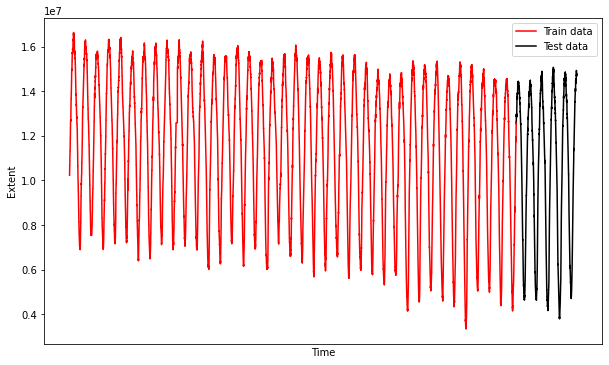

In [227]:
# Plotting the train and test set

plt.figure(figsize=(10,6))
plt.xlabel('Time')
plt.ylabel('Extent')
plt.xticks([])
plt.plot(train, 'red', label='Train data')
plt.plot(test, 'black', label='Test data')
plt.legend();

In [228]:
#dataframe for the test-split
df_test = df_model.iloc[-1892:]
df_test.head()

,date,extent
13947,2017-01-01,12643000.0
13948,2017-01-02,12644000.0
13949,2017-01-03,12713000.0
13950,2017-01-04,12954000.0
13951,2017-01-05,12956000.0


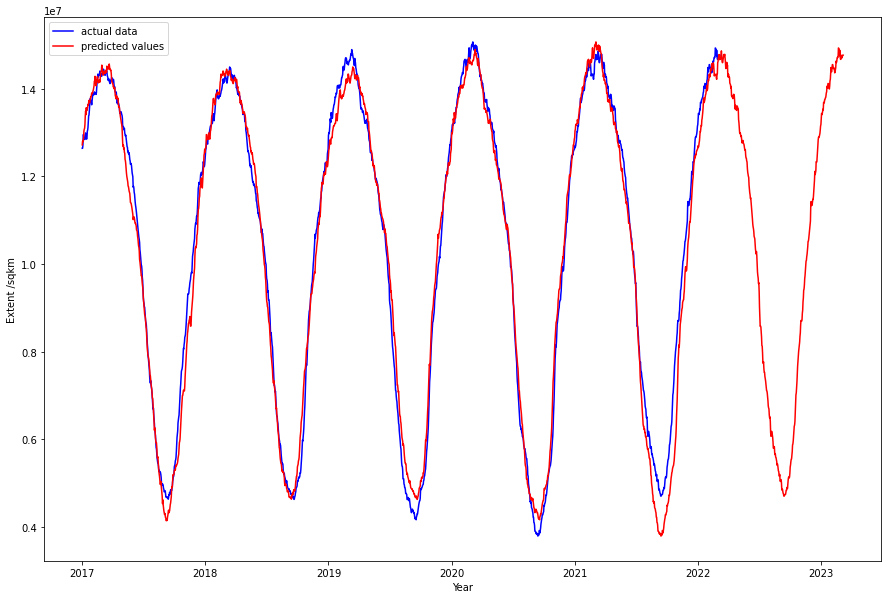

In [229]:
#plotting actual values and predicted values together
plt.figure(figsize=(15,10))
plt.xlabel('Year')
plt.ylabel('Extent /sqkm')
plt.plot(df_test['date'], df_test['extent'], 'b', label='actual data')
plt.plot(df_pred['date'], df_pred['y_pred'], 'r', label='predicted values')
plt.legend();

#### Evaluate the model

In [155]:
#merging the dataframes for the test-period together
df_error = pd.merge(df_test, df_pred, how='inner', on=['date'])
df_error['abs_error'] = abs(df_error['extent'] - df_error['y_pred'])
df_error['APE'] = df_error['abs_error']/df_error['extent']
df_error

,date,extent,y_pred,abs_error,APE
0,2017-01-01,12643000.0,12721000.0,78000.0,0.006169
1,2017-01-02,12644000.0,12806000.0,162000.0,0.012812
2,2017-01-03,12713000.0,12790000.0,77000.0,0.006057
3,2017-01-04,12954000.0,12829000.0,125000.0,0.009650
4,2017-01-05,12956000.0,12874000.0,82000.0,0.006329
...,...,...,...,...,...
1886,2022-03-03,14703000.0,14734000.0,31000.0,0.002108
1887,2022-03-04,14748000.0,14783000.0,35000.0,0.002373
1888,2022-03-05,14762000.0,14748000.0,14000.0,0.000948
1889,2022-03-06,14756000.0,14666000.0,90000.0,0.006099


In [156]:
print('Mean absolute error: ' + str(round(np.mean(df_error['abs_error']),3)))
# the same as: print(round(mean_absolute_error(df_error['extent'], df_error['y_pred']),3))
print('Mean absolute percentage error: ' + str(round(np.mean(df_error['APE']),3)))
print('RMSE: ' + str(round(mean_squared_error(df_error['extent'], df_error['y_pred'], squared=False),3)))

Mean absolute error: 339952.935
Mean absolute percentage error: 0.042
RMSE: 449322.539


### For Arima/Sarima-Model we need to check the stationarity 

ADF Test:
Null Hypothesis: Not Stationary
ADF Statistic: -19.141962
p-value: 0.000000
----------------------------------------
KPSS Test:
Null Hypothesis: Stationary
KPSS Statistic: 1.759549
p-value: 0.010000
----------------------------------------


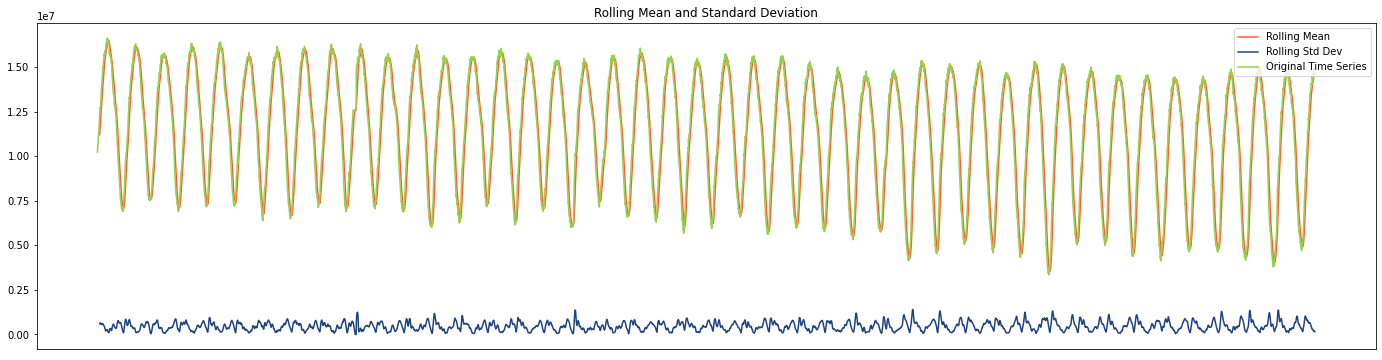

In [157]:
# Test for stationarity 

def stationarity_test(extent, t):
    
    # Calculate rolling mean and rolling standard deviation
    rolling_mean = extent.rolling(t).mean()
    rolling_std_dev = extent.rolling(t).std()
    
    # Plot the statistics
    plt.figure(figsize=(24,6))
    plt.plot(rolling_mean, color='#FF5A36', label='Rolling Mean')
    plt.plot(rolling_std_dev, color='#1E4485', label = 'Rolling Std Dev')
    plt.plot(extent, color='#99D04A',label='Original Time Series')
    plt.xticks([])
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    
    # ADF test
    print("ADF Test:")
    adf_test = adfuller(extent,autolag='AIC')
    print('Null Hypothesis: Not Stationary')
    print('ADF Statistic: %f' % adf_test[0])
    print('p-value: %f' % adf_test[1])
    print('----'*10)
    
    # KPSS test
    print("KPSS Test:")
    kpss_test = kpss(extent, regression='c', nlags="legacy", store=False)
    print('Null Hypothesis: Stationary')
    print('KPSS Statistic: %f' % kpss_test[0])
    print('p-value: %f' % kpss_test[1])
    print('----'*10)
    
stationarity_test(df_model['extent'], 30)

### SARIMA-Model

In [158]:
import statsmodels.api as sm
import matplotlib
import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pylab import rcParams

In [159]:
df_sarima = df_model.set_index('date')
df_sarima.head()

,extent
date,
1978-10-26,10231000.0
1978-10-27,10231000.0
1978-10-28,10420000.0
1978-10-29,10420000.0
1978-10-30,10557000.0


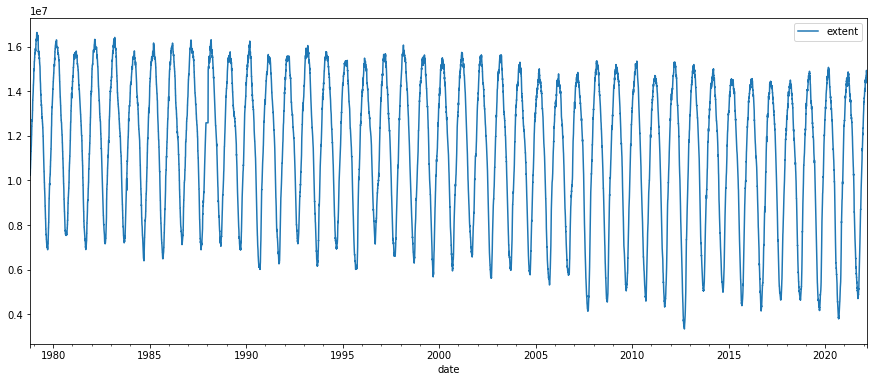

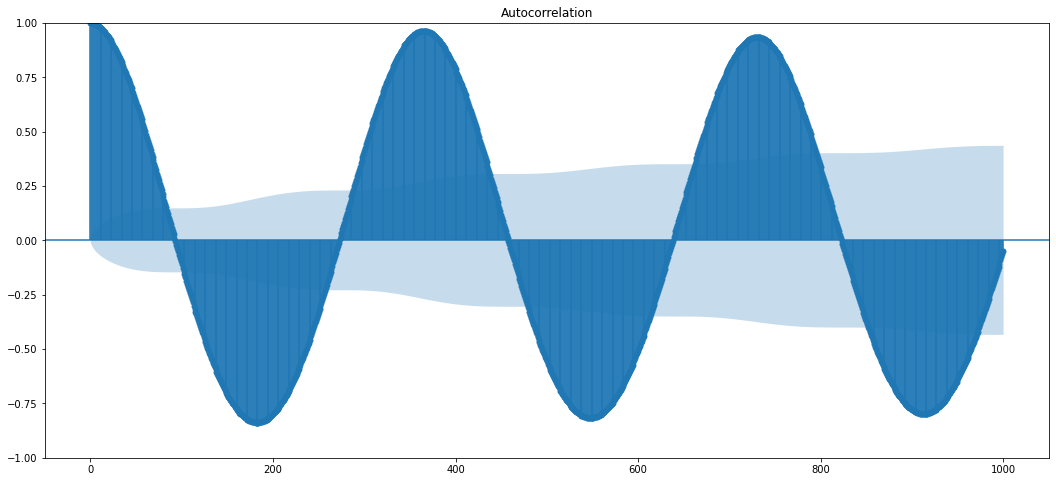

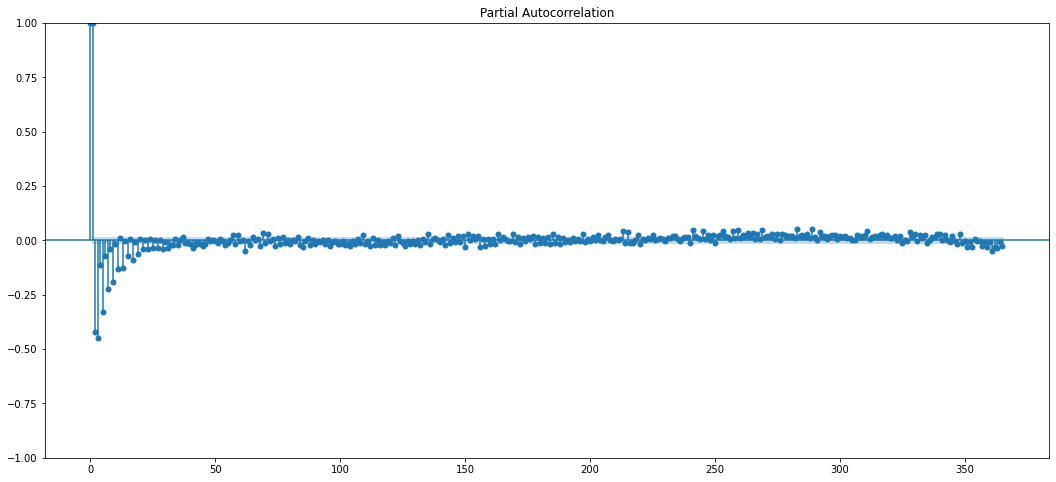

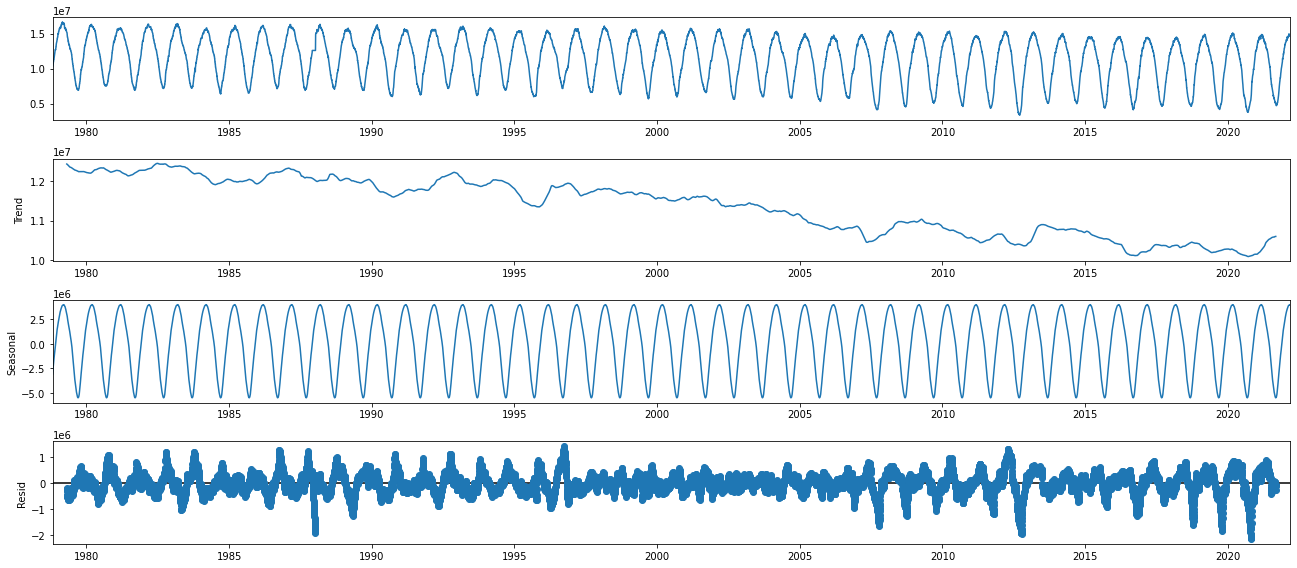

In [160]:
df_sarima.plot(figsize=(15, 6))
plt.show()

plot_acf(df_sarima, lags=1000)
plt.show()
plot_pacf(df_sarima, lags=365)
plt.show()

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(df_sarima, model='additive', period=365)
fig = decomposition.plot()
plt.show()

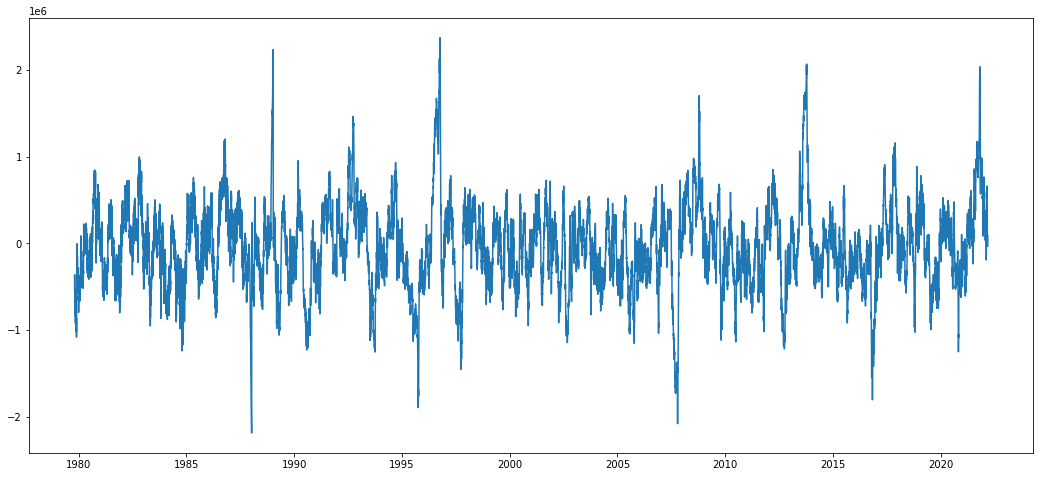

In [161]:
# De-trending the time series
df_sarima['extent_detrend'] = (df_sarima['extent'] - df_sarima['extent'].shift(365))
plt.plot(df_sarima['extent_detrend'])

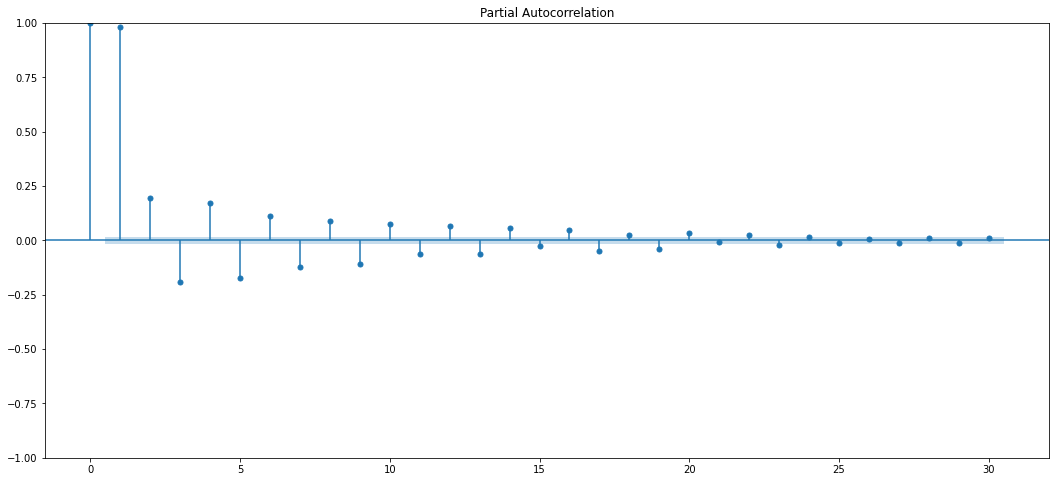

In [162]:
# Partial Autocorrelation Plot
pacf = plot_pacf(df_sarima['extent_detrend'].dropna(), lags=30)

In [163]:
df_sarima = df_sarima['extent_detrend']

In [164]:
#SARIMA(0, 1, 1)x(2, 1, 0, 12)
mod = sm.tsa.statespace.SARIMAX(df_sarima,
                                order=(0, 1, 1),
                                seasonal_order=(2, 1, 0, 12))
results = mod.fit(method = 'powell')
print(results.summary().tables[1])


Optimization terminated successfully.
         Current function value: 12.654567
         Iterations: 2
         Function evaluations: 97
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0036      0.007     -0.494      0.622      -0.018       0.011
ar.S.L12      -0.6138      0.003   -194.125      0.000      -0.620      -0.608
ar.S.L24      -0.2795      0.004    -77.279      0.000      -0.287      -0.272
sigma2      1.041e+10    8.9e-14   1.17e+23      0.000    1.04e+10    1.04e+10


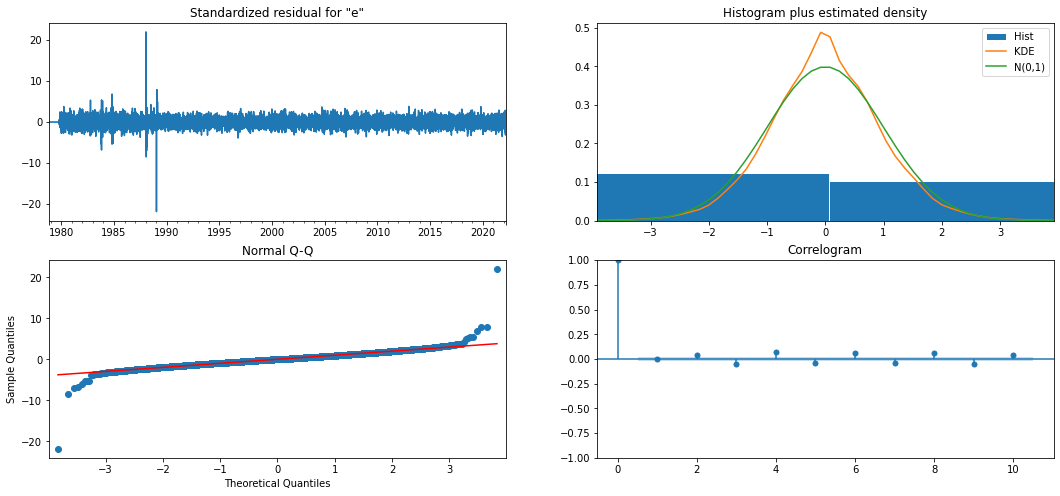

In [165]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

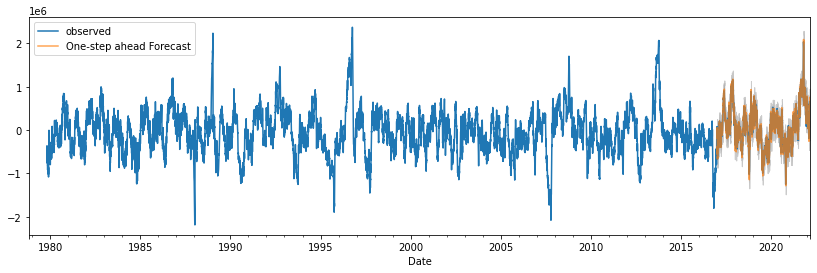

In [166]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = df_sarima.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
#ax.set_ylabel('AQI')
plt.legend()
plt.show()

#### monthly data

<AxesSubplot:xlabel='date'>

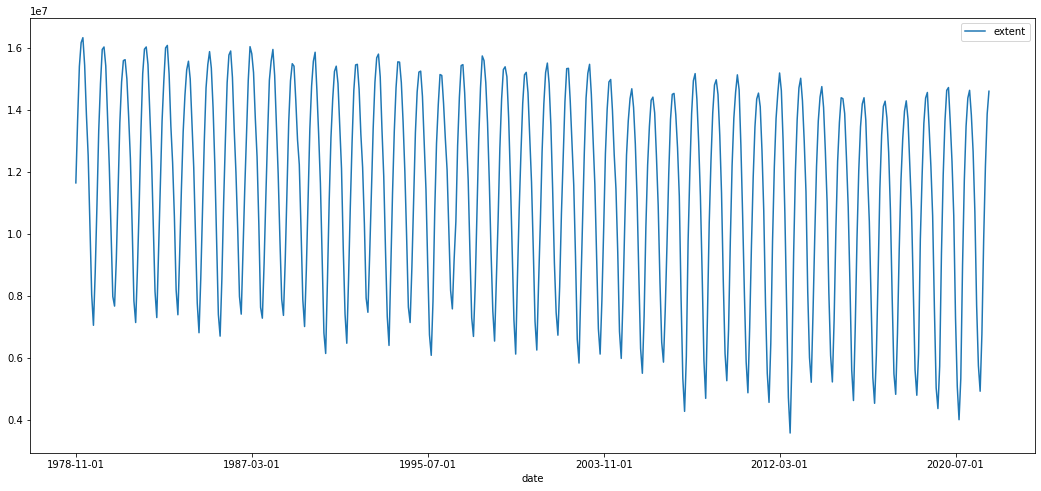

In [167]:
df_month_ext = pd.read_csv('../data/N_monthly.csv')
df_month_ext.plot(x='date', y='extent')

In [191]:
df_month_mod = df_month_ext[['date','extent']]
df_month_mod['date'] = pd.to_datetime(df_month_mod['date'])
#df_month_mod = df_month_mod.set_index('date')
df_month_mod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    520 non-null    datetime64[ns]
 1   extent  520 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 8.2 KB


#### Baseline

In [236]:
#create a y_pred column with values + 1year
y_month_pred = []
new_month = []
for i, day in enumerate(df_month_mod['date']):
    y = df_month_mod['extent'][i]
    nd = day + relativedelta(years=1)
    y_month_pred.append(y)
    new_month.append(nd)

df_newmonth = pd.DataFrame({'date':new_month, 'y_pred':y_month_pred})

df_month_pred = df_newmonth.iloc[-63:-12]
df_month_pred.tail()

,date,y_pred
503,2021-10-01,5330000.0
504,2021-11-01,8990000.0
505,2021-12-01,11730000.0
506,2022-01-01,13480000.0
507,2022-02-01,14390000.0


ADF Test:
Null Hypothesis: Not Stationary
ADF Statistic: -1.304730
p-value: 0.627005
----------------------------------------
KPSS Test:
Null Hypothesis: Stationary
KPSS Statistic: 1.697406
p-value: 0.010000
----------------------------------------


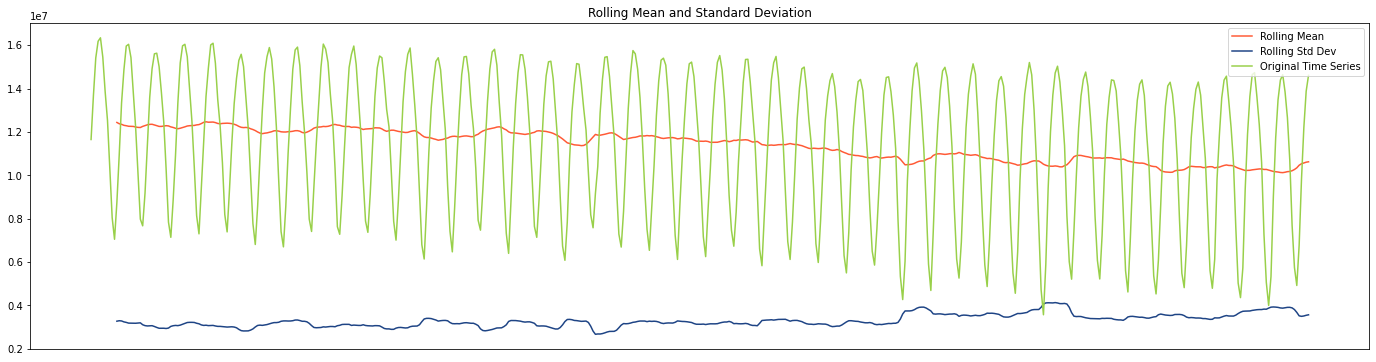

In [182]:
# checking for stationarity
stationarity_test(df_month_ext['extent'],12)

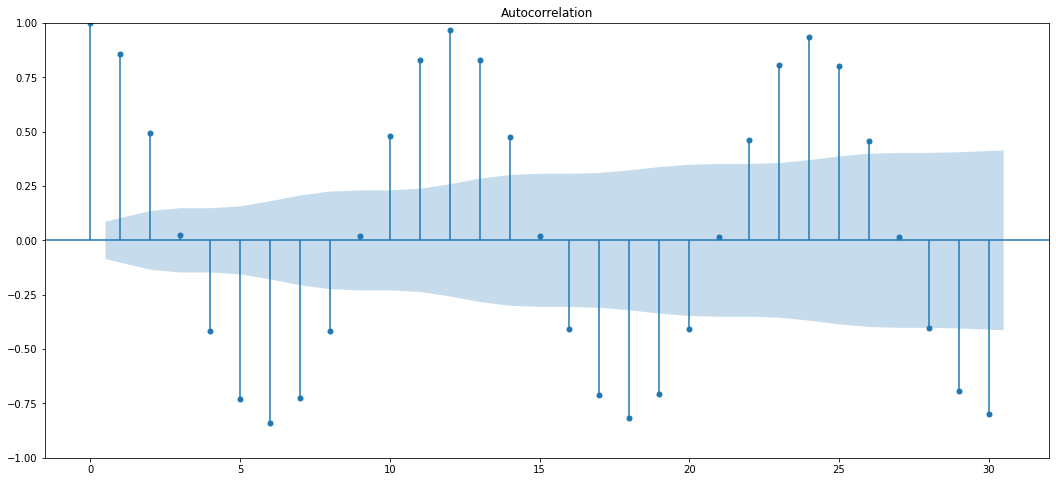

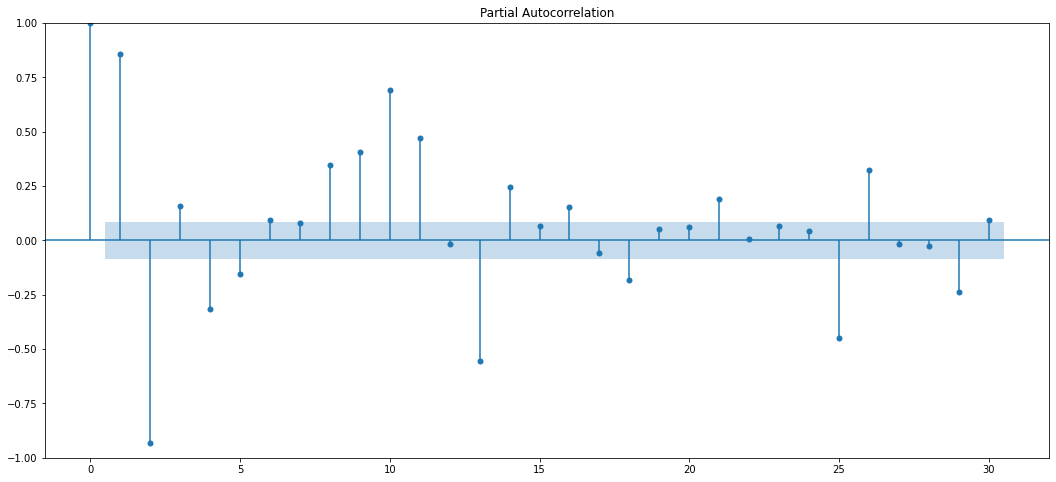

In [183]:
plot_acf(df_month_ext['extent'], lags=30)
plt.show()
plot_pacf(df_month_ext['extent'], lags=30)
plt.show()

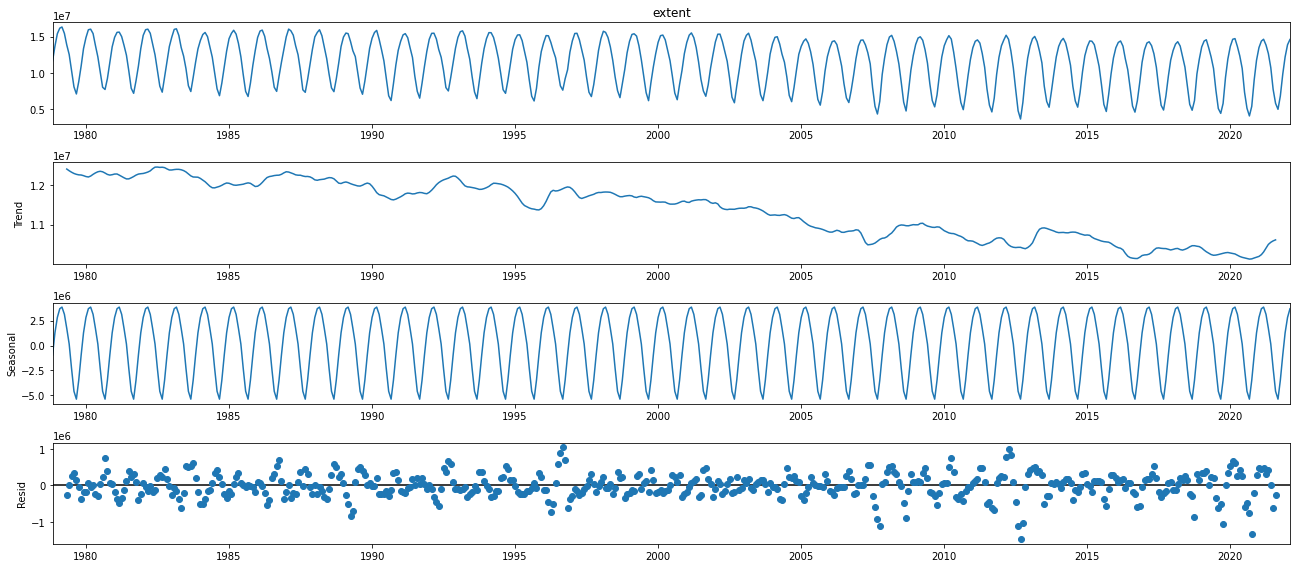

In [184]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(df_month_mod['extent'], model='additive', period=12)
fig = decomposition.plot()
plt.show()

In [185]:
# split into train and test sets (we use the last five years as test-data)

X_month = df_month_mod['extent']

train_size = int(len(X_month)*0.881)
train_month, test_month = X_month[1:train_size], X_month[train_size:]
train_month

date
1978-12-01    13670000.0
1979-01-01    15410000.0
1979-02-01    16180000.0
1979-03-01    16340000.0
1979-04-01    15450000.0
                 ...    
2016-08-01     5370000.0
2016-09-01     4530000.0
2016-10-01     6080000.0
2016-11-01     8660000.0
2016-12-01    11460000.0
Name: extent, Length: 457, dtype: float64

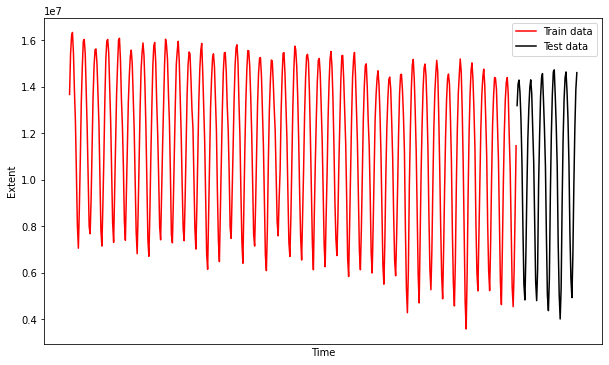

In [186]:
# Plotting the train and test set

plt.figure(figsize=(10,6))
plt.xlabel('Time')
plt.ylabel('Extent')
plt.xticks([])
plt.plot(train_month, 'red', label='Train data')
plt.plot(test_month, 'black', label='Test data')
plt.legend();

In [238]:
import itertools

p = range(0, 3)
d = range(1,2)
q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_month,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 1, 1) x (0, 1, 1, 12)
SARIMAX: (0, 1, 1) x (0, 1, 2, 12)
SARIMAX: (0, 1, 2) x (1, 1, 0, 12)
SARIMAX: (0, 1, 2) x (1, 1, 1, 12)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.37207D+01    |proj g|=  8.88177D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   8.882D-08   1.372D+01
  F =   13.720749546982301     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL          

 This problem is unconstrained.


ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:12542.765085941823
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.36050D+01    |proj g|=  3.97740D+00

At iterate    5    f=  1.32181D+01    |proj g|=  2.94454D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      6      8      1     0     0   1.947D-06   1.322D+01
  F =   13.218121564123154     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:12085.363109608563
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.33323D+01    |proj g|=  6.40476D+00


 This problem is unconstrained.



At iterate    5    f=  1.27988D+01    |proj g|=  5.18013D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     13      1     0     0   7.124D-06   1.280D+01
  F =   12.796969617842738     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 0)x(0, 1, 2, 12)12 - AIC:11702.430230708262
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.32221D+01    |proj g|=  6.58336D-06

           * * *

Tit   = total number of iterations
Tnf   = total number o

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.31758D+01    |proj g|=  1.48576D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      9      1     0     0   1.609D-06   1.318D+01
  F =   13.175811957747079     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:12048.69212938083
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.32862D+01    |proj g|=  3.51548D+00


 This problem is unconstrained.



At iterate    5    f=  1.28169D+01    |proj g|=  6.51476D-02

At iterate   10    f=  1.27926D+01    |proj g|=  2.73336D-02

At iterate   15    f=  1.27921D+01    |proj g|=  1.30106D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     20      1     0     0   1.301D-05   1.279D+01
  F =   12.792139249690631     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 0)x(1, 1, 2, 12)12 - AIC:11700.015274217238
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

 This problem is unconstrained.


ARIMA(0, 1, 0)x(2, 1, 0, 12)12 - AIC:11731.300568823395
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.28254D+01    |proj g|=  1.57345D-02


 This problem is unconstrained.



At iterate    5    f=  1.28246D+01    |proj g|=  1.31071D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      6      9      1     0     0   1.796D-06   1.282D+01
  F =   12.824615004681595     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 0)x(2, 1, 1, 12)12 - AIC:11729.698114278977
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.31939D+01    |proj g|=  2.83394D+00


 This problem is unconstrained.



At iterate    5    f=  1.27965D+01    |proj g|=  1.37035D-02

At iterate   10    f=  1.27931D+01    |proj g|=  2.14192D-02

At iterate   15    f=  1.27904D+01    |proj g|=  5.89537D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     29      1     0     0   7.772D-05   1.279D+01
  F =   12.790376430846006     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 0)x(2, 1, 2, 12)12 - AIC:11700.40405779325
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.32046D+01    |proj g|=  7.68300D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     10      1     0     0   7.576D-07   1.320D+01
  F =   13.204539271069038     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:12074.9488937571


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.32102D+01    |proj g|=  4.97139D+00

At iterate    5    f=  1.27947D+01    |proj g|=  4.88696D-02

At iterate   10    f=  1.27938D+01    |proj g|=  2.07569D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     16      1     0     0   7.497D-06   1.279D+01
  F =   12.793846908544497     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(0, 1, 2, 12)12 - AIC:11701.57607440967
RUNNING THE L-B

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.31729D+01    |proj g|=  8.54081D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     11      1     0     0   5.867D-06   1.317D+01
  F =   13.172876507566246     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:12048.009127915548
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.31099D+01    |proj g|=  2.24202D+00


 This problem is unconstrained.



At iterate    5    f=  1.28092D+01    |proj g|=  4.15028D-02

At iterate   10    f=  1.27942D+01    |proj g|=  1.95855D-02

At iterate   15    f=  1.27938D+01    |proj g|=  5.06141D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     22      1     0     0   1.403D-06   1.279D+01
  F =   12.793820292436600     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(1, 1, 2, 12)12 - AIC:11703.551747287052
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      4      8      1     0     0   8.814D-07   1.286D+01
  F =   12.859633193507527     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(2, 1, 0, 12)12 - AIC:11761.70473886588
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.28577D+01    |proj g|=  1.16353D-02


 This problem is unconstrained.



At iterate    5    f=  1.28570D+01    |proj g|=  2.56989D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      8     12      1     0     0   3.128D-06   1.286D+01
  F =   12.857007034348397     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(2, 1, 1, 12)12 - AIC:11761.304429394435
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.30508D+01    |proj g|=  1.80493D+00


 This problem is unconstrained.



At iterate    5    f=  1.27968D+01    |proj g|=  8.96910D-03

At iterate   10    f=  1.27946D+01    |proj g|=  1.23491D-02

At iterate   15    f=  1.27930D+01    |proj g|=  7.53385D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     18     23      1     0     0   4.623D-06   1.279D+01
  F =   12.792951259476030     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(2, 1, 2, 12)12 - AIC:11704.757451161091
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.31421D+01    |proj g|=  7.99986D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     10      1     0     0   7.609D-06   1.314D+01
  F =   13.142069108795248     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 2)x(0, 1, 1, 12)12 - AIC:12019.851165438857
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.31706D+01    |proj g|=  5.29034D+00


 This problem is unconstrained.



At iterate    5    f=  1.27318D+01    |proj g|=  5.43285D-02

At iterate   10    f=  1.27289D+01    |proj g|=  4.58101D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     16      1     0     0   9.660D-07   1.273D+01
  F =   12.728903896882130     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 2)x(0, 1, 2, 12)12 - AIC:11644.218161750267
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.32247D+01    |proj g|=  4.98770D-02

At iterate   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.31325D+01    |proj g|=  3.34507D-01

At iterate    5    f=  1.31096D+01    |proj g|=  6.20412D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      8     11      1     0     0   2.556D-05   1.311D+01
  F =   13.109636408016989     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 2)x(1, 1, 1, 12)12 - AIC:11992.207676927528
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.27439D+01    |proj g|=  5.97659D-02

At iterate   10    f=  1.27293D+01    |proj g|=  1.75324D-02

At iterate   15    f=  1.27289D+01    |proj g|=  8.44591D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     17     21      1     0     0   4.260D-05   1.273D+01
  F =   12.728856528246704     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 2)x(1, 1, 2, 12)12 - AIC:11646.174866817488
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

 This problem is unconstrained.



At iterate    5    f=  1.28283D+01    |proj g|=  3.77430D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      5     10      1     0     0   3.774D-05   1.283D+01
  F =   12.828337358776412     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 2)x(2, 1, 0, 12)12 - AIC:11735.10034592164
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.28270D+01    |proj g|=  2.11958D-02


 This problem is unconstrained.



At iterate    5    f=  1.28249D+01    |proj g|=  1.43692D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      9     14      1     0     0   4.584D-06   1.282D+01
  F =   12.824764275919916     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 2)x(2, 1, 1, 12)12 - AIC:11733.834548190804
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.30010D+01    |proj g|=  1.92919D+00


 This problem is unconstrained.



At iterate    5    f=  1.27317D+01    |proj g|=  8.51934D-03

At iterate   10    f=  1.27308D+01    |proj g|=  1.12828D-02

At iterate   15    f=  1.27282D+01    |proj g|=  4.21609D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     19     26      1     0     0   5.502D-06   1.273D+01
  F =   12.728189789518385     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 2)x(2, 1, 2, 12)12 - AIC:11647.565467619805
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.32344D+01    |proj g|=  1.81169D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     10      1     0     0   1.770D-06   1.323D+01
  F =   13.234388510398684     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:12102.231098504397
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.32421D+01    |proj g|=  4.99738D+00


 This problem is unconstrained.



At iterate    5    f=  1.28255D+01    |proj g|=  4.19969D-02

At iterate   10    f=  1.28239D+01    |proj g|=  4.19554D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     15      1     0     0   9.022D-07   1.282D+01
  F =   12.823900551376093     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 0)x(0, 1, 2, 12)12 - AIC:11729.04510395775
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.32141D+01    |proj g|=  2.96097D-02

           * *

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.32228D+01    |proj g|=  3.06993D-01

At iterate    5    f=  1.32031D+01    |proj g|=  9.94833D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      6      9      1     0     0   3.038D-05   1.320D+01
  F =   13.203124027521879     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:12075.655361154997


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.31411D+01    |proj g|=  2.25423D+00

At iterate    5    f=  1.28396D+01    |proj g|=  4.25235D-02

At iterate   10    f=  1.28242D+01    |proj g|=  1.87020D-02

At iterate   15    f=  1.28239D+01    |proj g|=  3.10514D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     21      1     0     0   8.426D-06   1.282D+01
  F =   12.823885729333444     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1,

 This problem is unconstrained.


ARIMA(1, 1, 0)x(2, 1, 0, 12)12 - AIC:11732.801290438776
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.28257D+01    |proj g|=  1.51728D-02


 This problem is unconstrained.



At iterate    5    f=  1.28247D+01    |proj g|=  1.21715D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      8     12      1     0     0   1.187D-06   1.282D+01
  F =   12.824660568686859     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 0)x(2, 1, 1, 12)12 - AIC:11731.73975977979
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.30817D+01    |proj g|=  1.81580D+00


 This problem is unconstrained.



At iterate    5    f=  1.28268D+01    |proj g|=  8.78716D-03

At iterate   10    f=  1.28247D+01    |proj g|=  1.20896D-02

At iterate   15    f=  1.28230D+01    |proj g|=  1.89302D-02

At iterate   20    f=  1.28228D+01    |proj g|=  1.00059D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     20     29      1     0     0   1.001D-04   1.282D+01
  F =   12.822825704686430     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 0)x(2, 1, 2, 12)12 - AIC:11732.062694083397
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.32019D+01    |proj g|=  1.20276D-02

At iterate   10    f=  1.31964D+01    |proj g|=  3.35427D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     17      1     0     0   1.108D-05   1.320D+01
  F =   13.195830011130539     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:12068.988630173313
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.32048D+01    |proj g|=  4.86331D+00


 This problem is unconstrained.



At iterate    5    f=  1.27950D+01    |proj g|=  4.64505D-02

At iterate   10    f=  1.27904D+01    |proj g|=  1.62538D-01

At iterate   15    f=  1.27798D+01    |proj g|=  9.61132D-03

At iterate   20    f=  1.27797D+01    |proj g|=  1.25265D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     31      1     0     0   2.334D-06   1.278D+01
  F =   12.779737999362471     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1)x(0, 1, 2, 12)12 - AIC:11690.680531417298
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X

 This problem is unconstrained.



At iterate    5    f=  1.32106D+01    |proj g|=  8.86423D-02

At iterate   10    f=  1.32029D+01    |proj g|=  4.84614D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     24      1     0     0   2.290D-06   1.320D+01
  F =   13.202875364167172     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:12075.428082848795
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.31930D+01    |proj g|=  3.02520D-01

At iterate   

 This problem is unconstrained.



At iterate   10    f=  1.31628D+01    |proj g|=  1.46426D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     21      1     0     0   5.139D-05   1.316D+01
  F =   13.162664690830375     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:12040.675527418964


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.31049D+01    |proj g|=  2.18920D+00

At iterate    5    f=  1.28093D+01    |proj g|=  3.98740D-02

At iterate   10    f=  1.27799D+01    |proj g|=  4.43215D-02

At iterate   15    f=  1.27787D+01    |proj g|=  6.62073D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     18     24      1     0     0   5.041D-05   1.278D+01
  F =   12.778628881391271     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1,

 This problem is unconstrained.



At iterate    5    f=  1.28215D+01    |proj g|=  1.16365D-01

At iterate   10    f=  1.28110D+01    |proj g|=  2.47865D-02

At iterate   15    f=  1.28107D+01    |proj g|=  2.05933D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     31      1     0     0   2.059D-06   1.281D+01
  F =   12.810734227725561     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1)x(2, 1, 0, 12)12 - AIC:11719.011084141162
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

 This problem is unconstrained.



At iterate    5    f=  1.28193D+01    |proj g|=  6.44261D-02

At iterate   10    f=  1.28099D+01    |proj g|=  2.28210D-02

At iterate   15    f=  1.28095D+01    |proj g|=  1.44713D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     16     27      1     0     0   4.043D-05   1.281D+01
  F =   12.809473927014499     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 1)x(2, 1, 1, 12)12 - AIC:11719.859169291252
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

 This problem is unconstrained.



At iterate    5    f=  1.27961D+01    |proj g|=  8.84040D-03

At iterate   10    f=  1.27858D+01    |proj g|=  9.12757D-02

At iterate   15    f=  1.27771D+01    |proj g|=  8.41167D-03

At iterate   20    f=  1.27753D+01    |proj g|=  3.01249D-02

At iterate   25    f=  1.27746D+01    |proj g|=  5.30012D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     26     41      1     0     0   2.057D-05   1.277D+01
  F =   12.774603726536691     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 1)x(2, 1, 2, 12)12 - AIC:11689.987806054536
RUNNING THE L-BFGS-B CODE

           * * *

Machine prec

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.72688D+01    |proj g|=  1.28850D+03

At iterate    5    f=  1.32598D+01    |proj g|=  3.59367D-01

At iterate   10    f=  1.31427D+01    |proj g|=  1.89294D-02


 This problem is unconstrained.



At iterate   15    f=  1.31324D+01    |proj g|=  1.69394D-02

At iterate   20    f=  1.31321D+01    |proj g|=  5.72697D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     24      1     0     0   5.727D-06   1.313D+01
  F =   13.132078692921597     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 2)x(0, 1, 1, 12)12 - AIC:12012.71992533034


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.42886D+01    |proj g|=  1.83362D+03

At iterate    5    f=  1.28689D+01    |proj g|=  3.48647D-01

At iterate   10    f=  1.27303D+01    |proj g|=  1.22463D-02

At iterate   15    f=  1.27146D+01    |proj g|=  6.00440D-02

At iterate   20    f=  1.27129D+01    |proj g|=  2.51967D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     32      1     0     0   4.171D-05   1.271D+01
  F =   12.712935476600258     

CONVERG

 This problem is unconstrained.



At iterate   15    f=  1.31759D+01    |proj g|=  1.15274D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     19      1     0     0   1.050D-05   1.318D+01
  F =   13.175926345981296     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 2)x(1, 1, 0, 12)12 - AIC:12052.796680226904
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90942D+01    |proj g|=  3.38093D+02


 This problem is unconstrained.



At iterate    5    f=  1.31150D+01    |proj g|=  1.36915D-01

At iterate   10    f=  1.30969D+01    |proj g|=  1.46578D-02

At iterate   15    f=  1.30956D+01    |proj g|=  2.17039D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     17     20      1     0     0   4.352D-06   1.310D+01
  F =   13.095617317599062     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 2)x(1, 1, 1, 12)12 - AIC:11981.394228285542
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

 This problem is unconstrained.



At iterate    5    f=  1.28747D+01    |proj g|=  3.87199D-01

At iterate   10    f=  1.27396D+01    |proj g|=  2.56210D-02

At iterate   15    f=  1.27232D+01    |proj g|=  5.10269D-02

At iterate   20    f=  1.27128D+01    |proj g|=  1.61686D-02

At iterate   25    f=  1.27122D+01    |proj g|=  1.72502D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     28     36      1     0     0   7.782D-06   1.271D+01
  F =   12.712187689276954     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 2)x(1, 1, 2, 12)12 - AIC:11632.939547999136
RUNNING THE L-BFGS-B CODE

           * * *

Machine prec

 This problem is unconstrained.



At iterate    5    f=  1.27994D+01    |proj g|=  1.16053D-01

At iterate   10    f=  1.27800D+01    |proj g|=  2.94737D-02

At iterate   15    f=  1.27790D+01    |proj g|=  6.53749D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     16     18      1     0     0   9.953D-06   1.278D+01
  F =   12.778954100920188     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 2)x(2, 1, 0, 12)12 - AIC:11691.964048241052


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.51485D+01    |proj g|=  1.68650D+02

At iterate    5    f=  1.27898D+01    |proj g|=  8.76628D-02

At iterate   10    f=  1.27781D+01    |proj g|=  2.48471D-02

At iterate   15    f=  1.27769D+01    |proj g|=  1.96362D-03

At iterate   20    f=  1.27769D+01    |proj g|=  2.34857D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     20     24      1     0     0   2.349D-05   1.278D+01
  F =   12.776879828581549     

CONVERG

 This problem is unconstrained.



At iterate    5    f=  1.28473D+01    |proj g|=  3.36260D-01

At iterate   10    f=  1.27296D+01    |proj g|=  1.56053D-02

At iterate   15    f=  1.27191D+01    |proj g|=  5.99607D-02

At iterate   20    f=  1.27135D+01    |proj g|=  6.33283D-03

At iterate   25    f=  1.27131D+01    |proj g|=  1.86132D-02

At iterate   30    f=  1.27111D+01    |proj g|=  1.64222D-02

At iterate   35    f=  1.27108D+01    |proj g|=  1.80434D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     39     48      1     0     0   1.508D-05   1.271D+01
  F =   12.710826943207524     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.32130D+01    |proj g|=  1.75931D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     10      1     0     0   5.382D-06   1.321D+01
  F =   13.212958786877032     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 1, 0)x(0, 1, 1, 12)12 - AIC:12084.644331205607
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.32144D+01    |proj g|=  5.00766D+00


 This problem is unconstrained.



At iterate    5    f=  1.28020D+01    |proj g|=  4.15510D-02

At iterate   10    f=  1.28004D+01    |proj g|=  2.25794D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     14      1     0     0   2.258D-05   1.280D+01
  F =   12.800369865506260     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 0)x(0, 1, 2, 12)12 - AIC:11709.538057072721
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.31575D+01    |proj g|=  3.50058D-02

           * 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.31670D+01    |proj g|=  3.04656D-01



 This problem is unconstrained.


At iterate    5    f=  1.31465D+01    |proj g|=  7.69464D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      8     11      1     0     0   2.272D-06   1.315D+01
  F =   13.146488995512893     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 1, 0)x(1, 1, 1, 12)12 - AIC:12025.890941898784
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.31156D+01    |proj g|=  2.28131D+00


 This problem is unconstrained.



At iterate    5    f=  1.28128D+01    |proj g|=  4.88486D-02

At iterate   10    f=  1.28008D+01    |proj g|=  2.07540D-02

At iterate   15    f=  1.28003D+01    |proj g|=  8.78217D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     18     22      1     0     0   1.575D-05   1.280D+01
  F =   12.800323246994148     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 0)x(1, 1, 2, 12)12 - AIC:11711.495447752652
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

 This problem is unconstrained.



At iterate    5    f=  1.27739D+01    |proj g|=  1.62570D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      6      8      1     0     0   8.125D-06   1.277D+01
  F =   12.773852249212784     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 1, 0)x(2, 1, 0, 12)12 - AIC:11685.300955780483
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.27717D+01    |proj g|=  2.17553D-02


 This problem is unconstrained.



At iterate    5    f=  1.27696D+01    |proj g|=  5.80859D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      8     12      1     0     0   1.249D-06   1.277D+01
  F =   12.769559204903038     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 1, 0)x(2, 1, 1, 12)12 - AIC:11683.377113281376
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.30261D+01    |proj g|=  1.83718D+00


 This problem is unconstrained.



At iterate    5    f=  1.27713D+01    |proj g|=  9.26799D-03

At iterate   10    f=  1.27696D+01    |proj g|=  7.75633D-03

At iterate   15    f=  1.27680D+01    |proj g|=  4.98575D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     18     27      1     0     0   4.938D-05   1.277D+01
  F =   12.767970947790968     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 0)x(2, 1, 2, 12)12 - AIC:11683.925446280944
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.31713D+01    |proj g|=  1.08273D-02

At iterate   10    f=  1.31700D+01    |proj g|=  1.30773D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     16      1     0     0   1.689D-06   1.317D+01
  F =   13.170021882819984     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 1, 1)x(0, 1, 1, 12)12 - AIC:12047.400000897465


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.31810D+01    |proj g|=  4.97065D+00

At iterate    5    f=  1.27632D+01    |proj g|=  5.12572D-02

At iterate   10    f=  1.27564D+01    |proj g|=  1.51685D-01

At iterate   15    f=  1.27531D+01    |proj g|=  4.55197D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     18     24      1     0     0   1.640D-05   1.275D+01
  F =   12.753083478128953     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2,

 This problem is unconstrained.



At iterate    5    f=  1.31449D+01    |proj g|=  3.29953D-02

At iterate   10    f=  1.31439D+01    |proj g|=  2.77440D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     20      1     0     0   3.177D-06   1.314D+01
  F =   13.143888626188478     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 1, 1)x(1, 1, 0, 12)12 - AIC:12023.514204336268


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.31625D+01    |proj g|=  3.18043D-01

At iterate    5    f=  1.31396D+01    |proj g|=  9.76553D-03

At iterate   10    f=  1.31381D+01    |proj g|=  3.16008D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     14     19      1     0     0   9.205D-06   1.314D+01
  F =   13.138049252660627     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 1, 1)x(1, 1, 1, 12)12 - AIC:12020.177016931813


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.30789D+01    |proj g|=  2.24711D+00

At iterate    5    f=  1.27747D+01    |proj g|=  3.50632D-02

At iterate   10    f=  1.27535D+01    |proj g|=  7.70053D-02

At iterate   15    f=  1.27521D+01    |proj g|=  2.39890D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     19     27      1     0     0   4.115D-05   1.275D+01
  F =   12.752082870051591     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2,

 This problem is unconstrained.



At iterate    5    f=  1.27594D+01    |proj g|=  5.85404D-02

At iterate   10    f=  1.27549D+01    |proj g|=  6.51857D-03

At iterate   15    f=  1.27548D+01    |proj g|=  1.93575D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     15     23      1     0     0   1.936D-05   1.275D+01
  F =   12.754807467764818     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 1)x(2, 1, 0, 12)12 - AIC:11669.894025537043
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

 This problem is unconstrained.



At iterate    5    f=  1.27568D+01    |proj g|=  3.97864D-02

At iterate   10    f=  1.27537D+01    |proj g|=  5.74817D-03

At iterate   15    f=  1.27533D+01    |proj g|=  1.05915D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     16     26      1     0     0   1.525D-05   1.275D+01
  F =   12.753344032474024     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 1)x(2, 1, 1, 12)12 - AIC:11670.556445681257
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

 This problem is unconstrained.



At iterate    5    f=  1.27633D+01    |proj g|=  1.42083D-02

At iterate   10    f=  1.27566D+01    |proj g|=  6.06585D-02

At iterate   15    f=  1.27538D+01    |proj g|=  7.89010D-04

At iterate   20    f=  1.27535D+01    |proj g|=  1.67954D-02

At iterate   25    f=  1.27523D+01    |proj g|=  6.31314D-02

At iterate   30    f=  1.27504D+01    |proj g|=  1.21205D-02

At iterate   35    f=  1.27503D+01    |proj g|=  7.38774D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     36     56      1     0     0   5.363D-05   1.275D+01
  F =   12.750312279659537     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   20    f=  1.38154D+01    |proj g|=  1.01143D+00

At iterate   25    f=  1.37261D+01    |proj g|=  2.59594D+01

At iterate   30    f=  1.36944D+01    |proj g|=  1.72174D-01

At iterate   35    f=  1.36934D+01    |proj g|=  1.86051D+00

At iterate   40    f=  1.36851D+01    |proj g|=  1.87866D+00

At iterate   45    f=  1.36794D+01    |proj g|=  5.00618D+00

At iterate   50    f=  1.36750D+01    |proj g|=  2.77384D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     83      1     0     0   2.774D+00   1.367D+01
  F =   13.674970348854350     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.98962D+03    |proj g|=  4.89829D+03

At iterate    5    f=  1.33383D+01    |proj g|=  1.00335D-01

At iterate   10    f=  1.33359D+01    |proj g|=  9.07468D-02

At iterate   15    f=  1.32885D+01    |proj g|=  1.78581D-01

At iterate   20    f=  1.32390D+01    |proj g|=  4.91974D-01

At iterate   25    f=  1.32261D+01    |proj g|=  9.93191D-01

At iterate   30    f=  1.32222D+01    |proj g|=  2.15407D-01

At iterate   35    f=  1.32215D+01    |proj g|=  1.23926D-01

At iterate   40    f=  1.32214D+01    |proj g|=  2.30184D-03

At iterate   45    f=  1.32214D+01    |proj g|=  1.50680D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.17799D+03    |proj g|=  2.83719D+04


 This problem is unconstrained.



At iterate    5    f=  1.31517D+01    |proj g|=  2.55098D-01

At iterate   10    f=  1.30825D+01    |proj g|=  2.53115D-01

At iterate   15    f=  1.28111D+01    |proj g|=  5.96097D-01

At iterate   20    f=  1.27270D+01    |proj g|=  1.53792D-01

At iterate   25    f=  1.27185D+01    |proj g|=  4.05177D-02

At iterate   30    f=  1.27117D+01    |proj g|=  4.02152D-02

At iterate   35    f=  1.27113D+01    |proj g|=  1.38707D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     39     62      1     0     0   3.267D-05   1.271D+01
  F =   12.711330011923270     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   10    f=  1.33907D+01    |proj g|=  3.63592D-01

At iterate   15    f=  1.33639D+01    |proj g|=  2.55360D-01

At iterate   20    f=  1.32468D+01    |proj g|=  1.42506D-01

At iterate   25    f=  1.32443D+01    |proj g|=  7.00063D-01

At iterate   30    f=  1.32429D+01    |proj g|=  9.77867D-01

At iterate   35    f=  1.32412D+01    |proj g|=  1.52455D-01

At iterate   40    f=  1.32409D+01    |proj g|=  8.31696D-02

At iterate   45    f=  1.32359D+01    |proj g|=  9.38041D-02

At iterate   50    f=  1.32355D+01    |proj g|=  4.52622D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     72   

 This problem is unconstrained.



At iterate    5    f=  1.33101D+01    |proj g|=  8.86826D-02

At iterate   10    f=  1.32657D+01    |proj g|=  2.23326D-01

At iterate   15    f=  1.32237D+01    |proj g|=  6.46207D-01

At iterate   20    f=  1.32062D+01    |proj g|=  6.82688D-01

At iterate   25    f=  1.32033D+01    |proj g|=  1.16752D-01

At iterate   30    f=  1.32031D+01    |proj g|=  1.22694D-01

At iterate   35    f=  1.31995D+01    |proj g|=  5.41779D-01



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     38     75      1     0     0   8.986D-02   1.320D+01
  F =   13.199492893575002     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 2)x(1, 1, 1, 12)12 - AIC:12078.336504727551
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.34178D+03    |proj g|=  3.13805D+04


 This problem is unconstrained.



At iterate    5    f=  1.31232D+01    |proj g|=  2.64517D-01

At iterate   10    f=  1.30139D+01    |proj g|=  1.85904D-01

At iterate   15    f=  1.28674D+01    |proj g|=  1.08522D-01

At iterate   20    f=  1.28273D+01    |proj g|=  7.56588D-02

At iterate   25    f=  1.28225D+01    |proj g|=  2.78173D-02

At iterate   30    f=  1.28215D+01    |proj g|=  1.51632D-01

At iterate   35    f=  1.28191D+01    |proj g|=  1.77078D-02

At iterate   40    f=  1.28183D+01    |proj g|=  3.44393D-02

At iterate   45    f=  1.28182D+01    |proj g|=  5.31007D-02

At iterate   50    f=  1.28181D+01    |proj g|=  2.95516D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.27688D+01    |proj g|=  3.49855D-02

At iterate   10    f=  1.27461D+01    |proj g|=  3.75143D-02

At iterate   15    f=  1.27445D+01    |proj g|=  8.36858D-03

At iterate   20    f=  1.27436D+01    |proj g|=  2.14450D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     24     41      1     0     0   8.164D-05   1.274D+01
  F =   12.743535733547917     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 2)x(2, 1, 0, 12)12 - AIC:11661.591660462796
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X

 This problem is unconstrained.



At iterate    5    f=  1.27634D+01    |proj g|=  2.01636D-02

At iterate   10    f=  1.27439D+01    |proj g|=  7.89491D-02

At iterate   15    f=  1.27421D+01    |proj g|=  8.36066D-03

At iterate   20    f=  1.27418D+01    |proj g|=  5.53612D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     20     39      1     0     0   5.536D-05   1.274D+01
  F =   12.741825755871627     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 2)x(2, 1, 1, 12)12 - AIC:11662.028740866666
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X

 This problem is unconstrained.



At iterate    5    f=  1.30972D+01    |proj g|=  2.71278D-01

At iterate   10    f=  1.29478D+01    |proj g|=  6.97448D-01

At iterate   15    f=  1.28590D+01    |proj g|=  2.87680D-01

At iterate   20    f=  1.28168D+01    |proj g|=  3.87343D-01

At iterate   25    f=  1.28112D+01    |proj g|=  8.31906D-02

At iterate   30    f=  1.28106D+01    |proj g|=  2.42495D-03

At iterate   35    f=  1.28105D+01    |proj g|=  1.68724D-03

At iterate   40    f=  1.28105D+01    |proj g|=  1.41095D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     43     72      1     0     0   1.066D-04   1.281D+01
  F =   12.8105277200

In [187]:
#SARIMA(0, 1, 1)x(2, 1, 0, 12)
mod = sm.tsa.statespace.SARIMAX(train_month,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
#fit the model
results = mod.fit(method = 'powell')
print(results.summary().tables[1])

Optimization terminated successfully.
         Current function value: 13.129975
         Iterations: 6
         Function evaluations: 358
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6328      0.095      6.653      0.000       0.446       0.819
ma.L1         -0.7755      0.069    -11.300      0.000      -0.910      -0.641
ar.S.L12      -0.4467      0.052     -8.573      0.000      -0.549      -0.345
ma.S.L12      -0.1391      0.040     -3.515      0.000      -0.217      -0.062
sigma2      7.727e+10   2.17e-13   3.56e+23      0.000    7.73e+10    7.73e+10


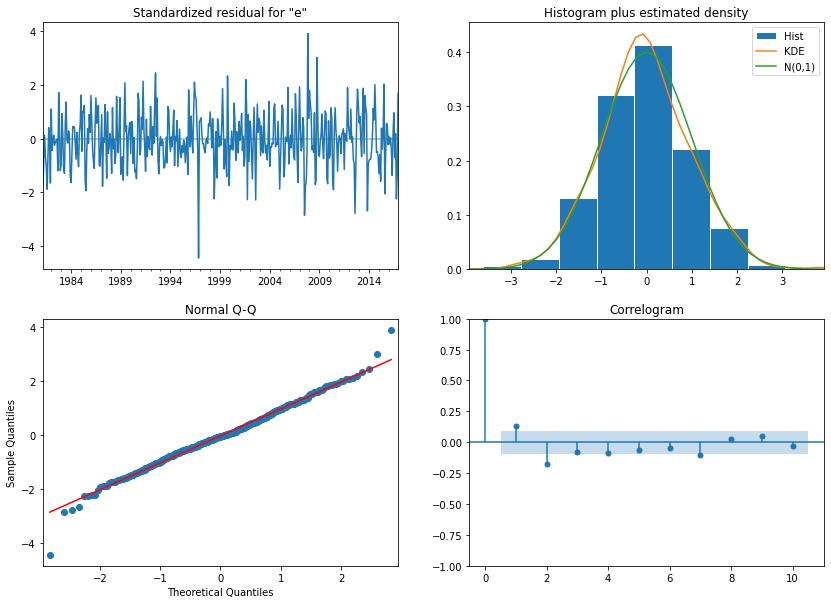

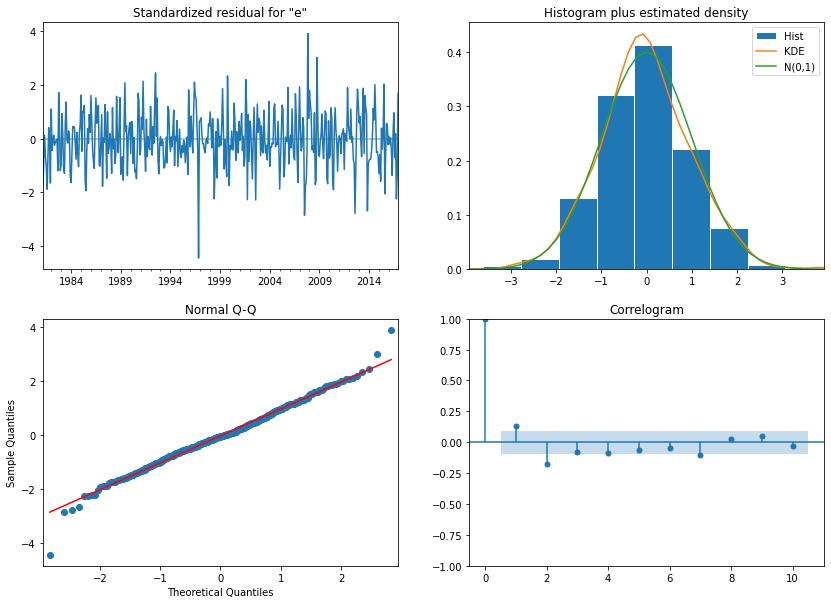

In [188]:
results.plot_diagnostics(figsize=(14,10))

In [204]:
# Forecasting values
forecast_values = results.get_forecast(steps=62) 
forecast_ci = forecast_values.conf_int()
forecast_values.summary_frame()
#fcv_series = pd.Series(forecast_values[0], index=test_month.index)



extent,mean,mean_se,mean_ci_lower,mean_ci_upper
2017-01-01,1.280421e+07,2.779775e+05,1.225939e+07,1.334904e+07
2017-02-01,1.358170e+07,3.661518e+05,1.286405e+07,1.429934e+07
2017-03-01,1.367863e+07,4.237101e+05,1.284817e+07,1.450909e+07
2017-04-01,1.308424e+07,4.674105e+05,1.216814e+07,1.400035e+07
2017-05-01,1.152698e+07,5.035365e+05,1.054006e+07,1.251389e+07
...,...,...,...,...
2021-10-01,4.061120e+06,2.957821e+06,-1.736102e+06,9.858342e+06
2021-11-01,6.762744e+06,3.009406e+06,8.644160e+05,1.266107e+07
2021-12-01,9.314617e+06,3.060077e+06,3.316976e+06,1.531226e+07
2022-01-01,1.068231e+07,3.143144e+06,4.521862e+06,1.684276e+07


In [202]:
type(forecast_values.predicted_mean)

pandas.core.series.Series

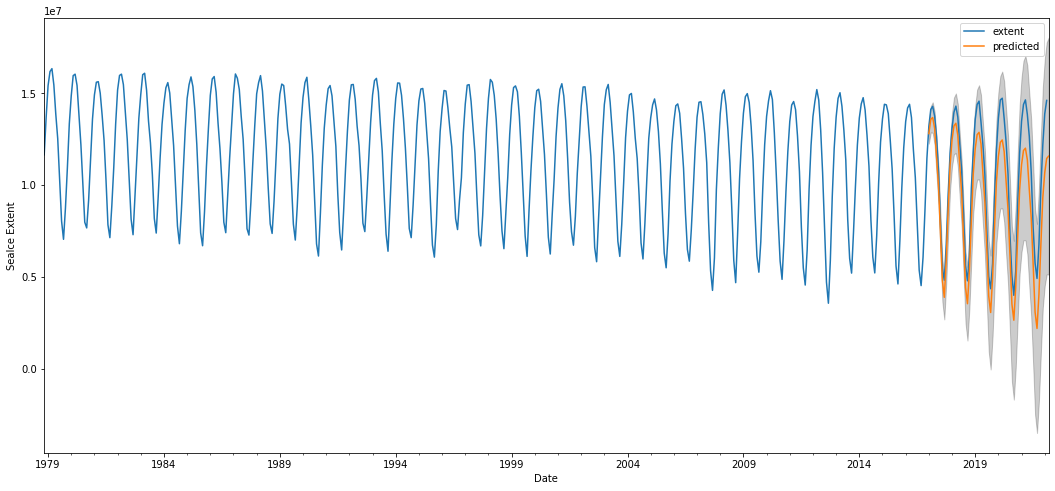

In [199]:
ax = df_month_mod.plot(x='date', y='extent')
forecast_values.predicted_mean.plot(ax=ax, label='predicted')

ax.fill_between(forecast_ci.index,
                forecast_ci.iloc[:, 0],
                forecast_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('SeaIce Extent')
plt.legend()

plt.show()

In [206]:
#evaluate the model
print('RMSE(Sarimax): ' + str(round(mean_squared_error(test_month, forecast_values.predicted_mean, squared=False),3)))


RMSE(Sarimax): 1747802.886
